In [7]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import precision_score
    
%matplotlib inline
import seaborn as sns

In [8]:
#read in the data
data = pd.read_csv('AggredgatedData.csv', sep=',', na_values=[" ", ""], index_col=0)

In [9]:
features = list(data.columns[1:-1])
X = data[features]
Y = data['2016ODabovenatavg']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

##I. Model Selection Using Grid Search and Random Search

This is a useful tool for parameter tuning, and examining which combinations of parameters yield the highest accuracy.
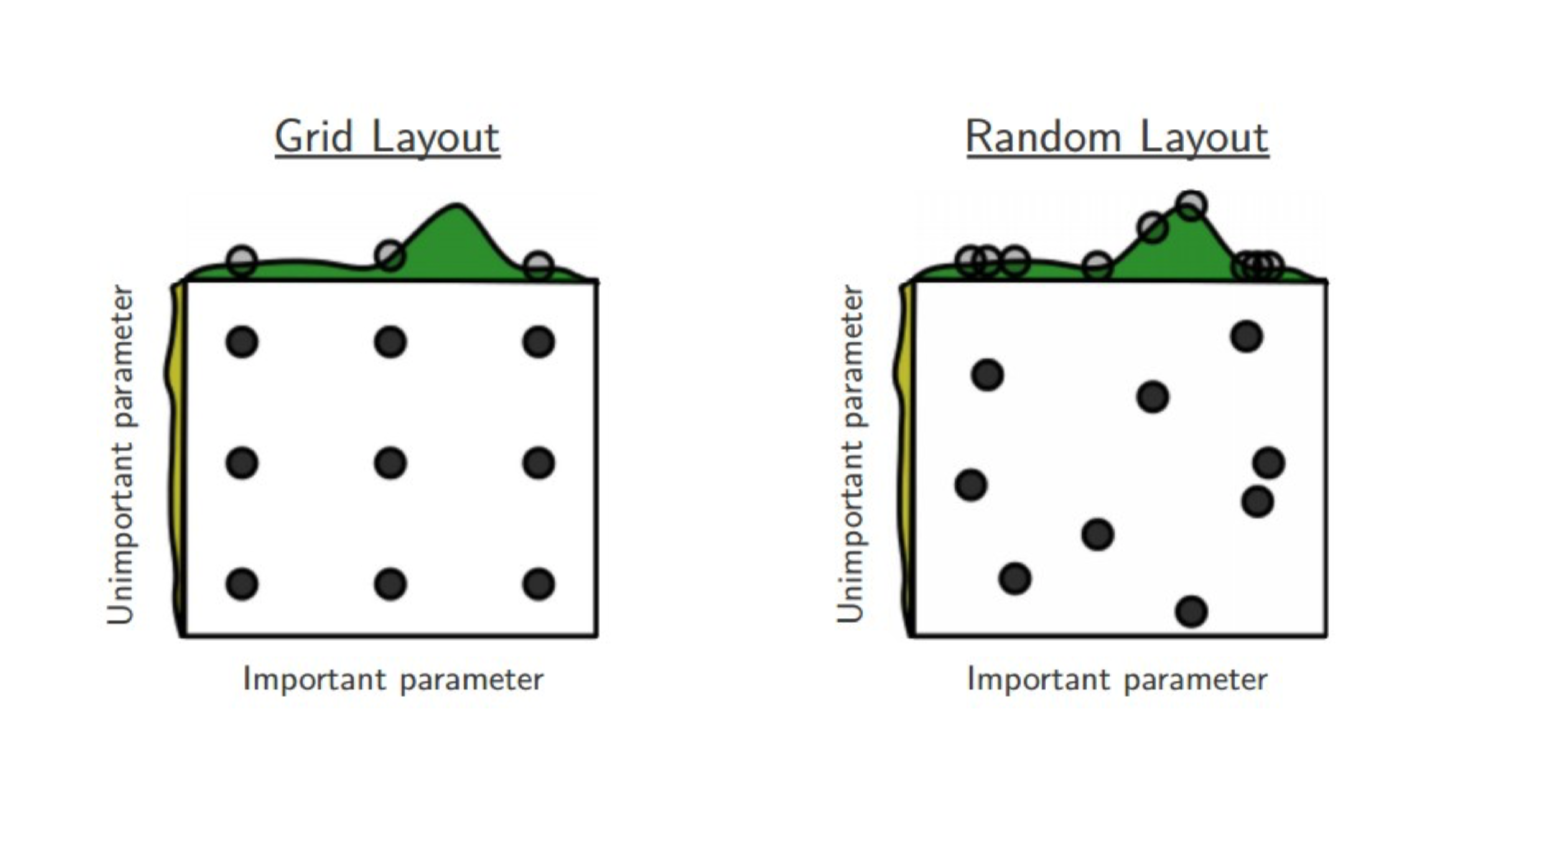
In some cases, randomized search yields better results if there are many parameters to tune. 

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [62]:
# Create space of candidate learning algorithms and their hyperparameters
classifiers = []
search_grid = [{'penalty': ['l1', 'l2'],
                 'C': [0.01, 0.1, 0.5, 1, 5]
                },
                {'n_estimators': [10, 50, 60, 100],
                 'criterion': ['gini', 'entropy'],
                 'max_features': ['sqrt','log2', None],
                },
                {'penalty': ['l1', 'l2'],
                 'loss': ['hinge', 'log', 'modified_huber'],
                 'tol': [1e-3, 1e-5, 1e-7]
                 },
                {'kernel': ['linear', 'rbf', 'sigmoid'],
                 'C': [0.1, 1, 10],
                 'gamma': [0.01, 0.1, 0.5, 1, 5, 10]} ]


classifiers.append(GridSearchCV(LogisticRegression(), search_grid[0], cv=5, verbose=0))

classifiers.append(GridSearchCV(RandomForestClassifier(), search_grid[1], cv=5, verbose=0))

classifiers.append(GridSearchCV(SGDClassifier(), search_grid[2], cv=5, verbose=0))

classifiers.append(GridSearchCV(SVC(), search_grid[3], cv=5, verbose=0))


In [63]:
search_dist = [{'penalty': ['l1', 'l2'],
                 'C': (0, 10)
                },
                {'n_estimators': (10, 100),
                 'criterion': ['gini', 'entropy'],
                 'max_features': ['sqrt','log2', None],
                },
                {'penalty': ['l1', 'l2'],
                 'loss': ['hinge', 'log', 'modified_huber'],
                 'tol': (0,1)
                 },
                {'kernel': ['linear', 'rbf', 'sigmoid'],
                 'C': (0, 10),
                 'gamma': (0, 10)} ]


classifiers.append(RandomizedSearchCV(LogisticRegression(), search_space[0], n_iter = 10))

classifiers.append(RandomizedSearchCV(RandomForestClassifier(), search_space[1], n_iter = 10))

classifiers.append(RandomizedSearchCV(SGDClassifier(), search_space[2], n_iter = 10))

classifiers.append(RandomizedSearchCV(SVC(), search_space[3], n_iter = 10))


In [64]:
for i in range(len(classifiers)):
    classifiers[i].fit(X_train, Y_train)
    print(classifiers[i].best_params_)

{'C': 0.1, 'penalty': 'l1'}
{'criterion': 'gini', 'max_features': None, 'n_estimators': 10}
{'loss': 'hinge', 'penalty': 'l2', 'tol': 0.001}
{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
{'penalty': 'l1', 'C': 1}
{'n_estimators': 100, 'max_features': None, 'criterion': 'gini'}
{'tol': 0.001, 'penalty': 'l2', 'loss': 'log'}
{'kernel': 'linear', 'gamma': 5, 'C': 1}


In [69]:
for i in range(len(classifiers)):
    classifiers[i].predict(X_test)

In [71]:
for i in range(len(classifiers)):
    print(classifiers[i].score(X_test,Y_test))

0.660377358491
0.962264150943
0.622641509434
0.622641509434
0.584905660377
0.962264150943
0.641509433962
0.641509433962


Grid Search:
  * Logistic Regression: 0.660377358491
  * Random Forest: 0.962264150943
  * Stochastic Gradient Descent: 0.622641509434
  * SVM: 0.622641509434
   
Randomized Search:
  * Logistic Regression: 0.584905660377
  * Random Forest: 0.962264150943
  * Stochastic Gradient Descent: 0.641509433962
  * SVM: 0.641509433962
  
Overall, Random Forest shows best performance regardless of which search method. 

##II. SVM

Pros: 
* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

Cons:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation

##Cross Validation

Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. 

This situation is called overfitting. 

To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. 

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. 

This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. 

To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

    * A model is trained using k-1 of the folds as training data;
    * the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).
    
The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

Linear kernel = Straight Line (hyperplane) as the decision boundary
* rarely used in practice

RBF = commonly used kernel in SVC
2 parameters:
* gamma
* C

Gamma:
*  'spread' of the kernel and therefore the decision region.
* low gamma -> the 'curve' of the decision boundary is very low and thus the decision region is very broad (underfitting)
* gamma = 10 (The decision boundary starts to be highly effected by individual data points (i.e. variance)).
* high gamma -> the 'curve' of the decision boundary is high, which creates islands of decision-boundaries around data points (overfitting)
* If gamma is ‘auto’ then 1/n_features will be used instead.

C:
* penalty for misclassifying a data point
* small C -> classifier is okay with misclassified data points (high bias, low variance)
* big C -> classifier is heavily penalized for misclassified data and therefore bends over backwards avoid any misclassified data points (low bias, high variance)

C > 10 is too slow

degree : int, optional (default=3)

* Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

In [35]:
kernels = ['linear', 'rbf', 'sigmoid']

for i in kernels:
    for j, C in enumerate((0.01, 1, 10, 100)):
        for k, D in enumerate((1, 10)):
            clf = SVC(C=D, cache_size=200, class_weight=None, coef0=0.0,
                      decision_function_shape='ovr', degree=3, gamma=C, kernel=i,
                      max_iter=-1, probability=False, random_state=None, shrinking=True,
                      tol=0.001, verbose=False)
            clf.fit(X_train, Y_train) 
            scores = cross_val_score(clf, X, Y, cv = 10)

            print ("Kernel: %s | Gamma: %0.2f | C: %i" % (i, C, D))
            print scores
            print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Kernel: linear | Gamma: 0.01 | C: 1
[ 0.70588235  0.6875      0.5         0.75        0.8125      0.5625      0.875
  0.625       0.8         0.8       ]
Accuracy: 0.71 (+/- 0.23)
Kernel: linear | Gamma: 0.01 | C: 10
[ 0.52941176  0.8125      0.5625      0.625       0.75        0.6875      0.875
  0.625       0.6         0.53333333]
Accuracy: 0.66 (+/- 0.23)
Kernel: linear | Gamma: 1.00 | C: 1
[ 0.70588235  0.6875      0.5         0.75        0.8125      0.5625      0.875
  0.625       0.8         0.8       ]
Accuracy: 0.71 (+/- 0.23)
Kernel: linear | Gamma: 1.00 | C: 10
[ 0.52941176  0.8125      0.5625      0.625       0.75        0.6875      0.875
  0.625       0.6         0.53333333]
Accuracy: 0.66 (+/- 0.23)
Kernel: linear | Gamma: 10.00 | C: 1
[ 0.70588235  0.6875      0.5         0.75        0.8125      0.5625      0.875
  0.625       0.8         0.8       ]
Accuracy: 0.71 (+/- 0.23)
Kernel: linear | Gamma: 10.00 | C: 10
[ 0.52941176  0.8125      0.5625      0.625       0.75     

### Ideal Model

Kernel: rbf | Gamma: 0.01 | C: 1

[ 0.76470588  0.6875      0.5625      0.6875      0.875       0.6875
  0.6875      0.6875      0.6         0.8       ]
  
Accuracy: 0.70 (+/- 0.17)

In [123]:
clf0 = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
          max_iter=-1, probability=False, random_state=None, shrinking=True,
          tol=0.001, verbose=False)
clf0.fit(X_train, Y_train) 
scores = cross_val_score(clf0, X, Y, cv = 10)

In [124]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.71 (+/- 0.23)


In [125]:
clf0.coef_

array([[  2.63848801e-01,  -6.68540451e-02,   3.09387286e-01,
         -2.05750837e-01,   1.34634014e+00,   1.40482994e-01,
          7.49506633e-01,   1.59324072e+00,   3.68813954e-01,
          3.97217579e-02,  -3.60074262e-01,   1.83569736e-01,
         -2.72166587e-01,  -2.27081181e-01,   8.76271007e-03,
          3.60658592e-01,  -4.52500113e-01,  -2.06844360e-01,
          2.52252443e-02,   3.51946070e-01,  -8.41550902e-01,
          5.08848354e-01,  -2.47331720e-01,   7.35406646e-01,
         -1.60632132e-02,  -1.61889112e-01,   5.63491887e-01,
         -3.35239154e-01,   8.46799623e-04,   2.23128289e-01,
          5.84754921e-02,  -2.64266052e-01,   1.39304776e-01,
          1.76294694e-02,  -5.67709251e-02,  -7.26662105e-01,
          1.72026303e-03,  -1.46720138e-02,   5.96602027e-01,
          2.40489622e-03]])

In [126]:
clf0.intercept_

array([-1.91970688])

##II. Logistic Regression

* binary classifier

L1 regularization (also called least absolute deviations) 
* push feature coefficients to 0, creating a method for feature selection. 
* as C decreases, more coefficients become 0.

In [7]:
from sklearn.linear_model import LogisticRegression

In [12]:
clf1 = LogisticRegression(penalty='l1', dual=False, tol=0.01, C=100.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', 
                   max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
clf1.fit(X_train, Y_train) 

print(clf1.predict(X_test))

NameError: name 'LogisticRegression' is not defined

In [87]:
scores = cross_val_score(clf1, X, Y, cv = 10)
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.64705882  0.6875      0.5         0.5         0.6875      0.6875      0.875
  0.5625      0.6         0.73333333]
Accuracy: 0.65 (+/- 0.22)


In [88]:
#Comparison of the sparsity (% of zero coefficients) of solutions when L1 and L2 penalty 
#are used for different values of C. 
#We can see that large values of C give more freedom to the model. 
#Conversely, smaller values of C constrain the model more. 
#In the L1 penalty case, this leads to sparser solutions.

for i, C in enumerate((100, 1, 0.01)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01)
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01)
    clf_l1_LR.fit(X, Y)
    clf_l2_LR.fit(X, Y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

    print("C=%.2f" % C)
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)
    print("score with L1 penalty: %.4f" % clf_l1_LR.score(X, Y))
    print("Sparsity with L2 penalty: %.2f%%" % sparsity_l2_LR)
    print("score with L2 penalty: %.4f" % clf_l2_LR.score(X, Y))

C=100.00
Sparsity with L1 penalty: 5.00%
score with L1 penalty: 0.8491
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.8491
C=1.00
Sparsity with L1 penalty: 57.50%
score with L1 penalty: 0.7736
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.7925
C=0.01
Sparsity with L1 penalty: 95.00%
score with L1 penalty: 0.6415
Sparsity with L2 penalty: 0.00%
score with L2 penalty: 0.7421


## III. Stochastic Gradient Descent (SGD)

Pros:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).

Cons:
* requires a number of hyperparameters such as the regularization parameter and the number of iterations.
* sensitive to feature scaling.

In [15]:
from sklearn.linear_model import SGDClassifier

In [89]:
clf3 = SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

clf3.fit(X_train, Y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [90]:
clf3.predict(X_test)

array([ True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [91]:
clf3.coef_

array([[ -5.23217789e+01,  -3.27011118e+01,  -2.61608895e+01,
         -2.61608895e+01,   8.50228908e+01,   5.88620013e+01,
          1.95828386e+02,   2.36071445e+02,   1.31615923e+02,
          1.14939664e+01,   1.12390395e+01,  -2.20715014e+00,
         -4.77775141e+01,  -4.15829428e+01,   3.31181442e+01,
          2.51492789e+01,  -2.71001948e+01,  -3.98133628e+01,
          5.95502310e+00,   2.28872008e+01,   4.94410705e+00,
          9.04832470e+00,   7.46644264e+00,   3.59557058e+01,
         -1.45118112e+01,  -5.14007471e+00,   3.04663837e+00,
         -1.71934843e+01,   4.97520380e+01,   4.02451916e+01,
          3.69608367e+01,  -1.71696321e+02,  -6.73574243e+01,
          4.06115108e-01,  -6.76913015e-01,  -3.44146501e+01,
         -1.75283087e-01,  -3.19077067e-01,   3.70045782e+01,
          6.77973026e-02]])

In [92]:
clf3.intercept_   

array([-42.41118979])

In [93]:
scores = cross_val_score(clf3, X, Y, cv = 10)
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[ 0.76470588  0.875       0.5         0.625       0.5625      0.5625      0.75
  0.75        0.66666667  0.66666667]
Accuracy: 0.67 (+/- 0.22)


##IV. Random Forest Classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. 

The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

Pros:

* It runs efficiently on large data bases.
* It can handle thousands of input variables without variable deletion.
* It gives estimates of what variables are important in the classification.
* It generates an internal unbiased estimate of the generalization error as the forest building progresses.
* It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
* It has methods for balancing error in class population unbalanced data sets.
* Generated forests can be saved for future use on other data.
* Prototypes are computed that give information about the relation between the variables and the classification.
* It computes proximities between pairs of cases that can be used in clustering, locating outliers, or (by scaling) give interesting views of the data.
* The capabilities of the above can be extended to unlabeled data, leading to unsupervised clustering, data views and outlier detection.
* It offers an experimental method for detecting variable interactions.

## Number of Trees in RF


Random forests does not overfit. You can run as many trees as you want. It is fast. Running on a data set with 50,000 cases and 100 variables, it produced 100 trees in 11 minutes on a 800Mhz machine. For large data sets the major memory requirement is the storage of the data itself, and three integer arrays with the same dimensions as the data. If proximities are calculated, storage requirements grow as the number of cases times the number of trees.

In random forests, there is no need for cross-validation or a separate test set to get an unbiased estimate of the test set error. It is estimated internally, during the run, as follows:

Each tree is constructed using a different bootstrap sample from the original data. About one-third of the cases are left out of the bootstrap sample and not used in the construction of the kth tree.

* https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks

The RandomForestClassifier is trained using bootstrap aggregation, where each new tree is fit from a bootstrap sample of the training observations z_i = (x_i, y_i). 

The out-of-bag (OOB) error is the average error for each z_i calculated using predictions from the trees that do not contain z_i in their respective bootstrap sample. 

This allows the RandomForestClassifier to be fit and validated whilst being trained. 

* T. Hastie, R. Tibshirani and J. Friedman, “Elements of Statistical Learning Ed. 2”, p592-593, Springer, 2009.

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
clf4 = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, 
                              min_samples_split=2, 
                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                              max_features='auto', 
                       max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                       bootstrap=True, oob_score=True, n_jobs=1, random_state=None, verbose=0, 
                       warm_start=False, class_weight=None)
            
clf4.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [6]:
clf4.score(X_test, Y_test)

0.92452830188679247

##Figuring out ok counties

In [15]:
preds = clf4.predict(X) 
itemindex = np.where(preds==False)
ok_counties = data.ix[itemindex]
index_ok_counties = ok_counties.index.values

In [16]:
data2017 = pd.read_csv('AggregatedData2017.csv', sep=',', na_values=[" ", ""], index_col=0)
data2018 = pd.read_csv('AggregatedData2018.csv', sep=',', na_values=[" ", ""], index_col=0)

ok_counties_2017 = data2017.ix[index_ok_counties]
ok_counties_2018 = data2018.ix[index_ok_counties]

In [17]:
features = list(ok_counties_2017.columns[1:-1])
X = ok_counties_2017[features]
preds = clf4.predict(X) 
itemindex = np.where(preds==True)
risky_counties = data2017.ix[itemindex]

In [18]:
risky_counties

,County,Rural,Rehab_Count,EMS_COUNT,hospital_count,dropbox_247availability,dropbox_count,1yrlag,5yrlag,10yrlag,...,ER_5yrlag,ER_10yrlag,drug_ER_Visits_2017,teenage_pregnancy_2017,2017_children_poverty,2017_death_rate,2017_birth_rate,2017_prescription,2017_ODRate,2017ODabovenatavg
5,Banks,1,0,1,0,0,1,-0.076373,-0.261098,0.231503,...,8.221374,16.660819,0.006040,0.011871,0.213006,0.008834,0.011875,0.386764,0.000198,True
7,Bartow,0,1,1,1,1,2,0.039000,0.283471,1.727376,...,13.701365,17.329787,0.008615,0.011750,0.193598,0.008704,0.012125,0.990520,0.000208,True
11,Bleckley,1,1,1,1,0,1,0.772826,0.772826,0.000000,...,7.726742,0.000000,0.003377,0.013029,0.333089,0.009503,0.009727,1.292364,0.000135,False
15,Bulloch,0,1,1,2,0,5,-0.188242,-0.323535,0.352931,...,9.737864,8.102881,0.002212,0.010492,0.336884,0.007535,0.012205,0.743703,0.000054,False
16,Burke,1,1,1,0,0,1,0.117279,3.469115,0.489705,...,9.630363,9.560656,0.003221,0.014984,0.301513,0.011122,0.011950,0.828036,0.000198,True
20,Candler,1,1,1,1,0,1,0.119287,0.000000,0.119287,...,10.980398,10.878870,0.005607,0.014086,0.441832,0.011954,0.011292,1.788549,0.000103,False
21,Carroll,0,1,1,3,1,3,-0.000454,0.749205,0.166136,...,14.424508,18.689944,0.007049,0.015083,0.303207,0.009077,0.013053,1.107233,0.000238,True
25,Chattahoochee,1,0,0,0,1,1,0.000000,-0.382371,-0.382371,...,0.000000,0.000000,0.000272,0.017078,0.246748,0.002168,0.015914,0.000000,0.000058,False
26,Chattooga,1,1,1,0,0,1,0.085955,0.085955,0.900421,...,17.525735,15.521311,0.005039,0.029179,0.341933,0.012412,0.012560,1.385000,0.000308,True
31,Clinch,1,0,1,1,0,1,-0.804311,0.000000,-0.804311,...,0.000000,0.000000,0.010408,0.013539,0.417342,0.007802,0.015177,1.539326,0.000029,False


In [19]:
features = list(ok_counties_2018.columns[1:-1])
X = ok_counties_2018[features]
preds = clf4.predict(X) 
itemindex = np.where(preds==True)
risky_counties = data2018.ix[itemindex]

In [20]:
risky_counties

,County,Rural,Rehab_Count,EMS_COUNT,hospital_count,dropbox_247availability,dropbox_count,1yrlag,5yrlag,10yrlag,...,ER_5yrlag,ER_10yrlag,drug_ER_Visits_2018,teenage_pregnancy_2018,2018_children_poverty,2018_death_rate,2018_birth_rate,2018_prescription,2018_ODRate,2018ODabovenatavg
5,Banks,1,0,1,0,0,1,0.084346,0.000000,0.335376,...,24.883436,24.263473,0.008438,0.010746,0.195805,0.009037,0.011996,0.350527,0.000212,True
7,Bartow,0,1,1,1,1,2,0.069945,0.795779,0.459071,...,20.125654,21.926136,0.012105,0.010084,0.184184,0.008822,0.011669,0.958487,0.000221,True
11,Bleckley,1,1,1,1,0,1,0.060701,-0.059781,0.880438,...,10.874672,10.936358,0.004595,0.012505,0.340666,0.009164,0.009435,1.237112,0.000142,False
15,Bulloch,0,1,1,2,0,5,-0.145647,-0.566545,-0.133090,...,5.944272,11.530726,0.002243,0.009892,0.343252,0.007868,0.012269,0.640406,0.000045,False
16,Burke,1,1,1,0,0,1,0.170879,0.744265,0.744265,...,15.343511,7.234615,0.004282,0.012515,0.255732,0.011232,0.010780,0.811739,0.000232,True
18,Calhoun,1,0,1,0,0,1,0.155499,0.000000,0.000000,...,0.000000,0.000000,0.001095,0.000000,0.419052,0.007302,0.006656,0.032971,0.000059,False
20,Candler,1,1,1,1,0,1,0.013400,0.000000,0.000000,...,0.000000,15.526910,0.007735,0.011502,0.445755,0.012140,0.010810,1.889093,0.000104,False
21,Carroll,0,1,1,3,1,3,0.022961,0.908659,-0.045670,...,21.191011,35.305147,0.009875,0.014101,0.310591,0.009075,0.013013,1.056543,0.000241,True
25,Chattahoochee,1,0,0,0,1,1,0.000000,-0.382371,0.000000,...,0.000000,0.000000,0.000297,0.016554,0.250448,0.002102,0.013903,0.000000,0.000060,False
26,Chattooga,1,1,1,0,0,1,0.149886,1.913691,0.248725,...,18.824022,36.157068,0.007097,0.030153,0.349069,0.012562,0.012883,1.456000,0.000356,True
